In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import pandas as pd
import numpy as np

import scanpy as sc

from thalamus_merfish_analysis import ccf_plots as cplots
from thalamus_merfish_analysis import abc_load as abc

import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

%matplotlib inline

## Load abc atlas data

In [3]:
version = '20230830'
adata_th_zi = abc.load_adata_thalamus(version=version, 
                             transform='raw', # will manually norm+log2 later
                             subset_to_TH_ZI=True, 
                             with_metadata=True, 
                             flip_y=True,
                             round_z=True,
                             with_colors=False) # need colors to come with

In [6]:
adata_th_zi

AnnData object with n_obs × n_vars = 227191 × 550
    obs: 'brain_section_label', 'average_correlation_score', 'class', 'cluster', 'cluster_alias', 'left_hemisphere', 'neurotransmitter', 'parcellation_division', 'parcellation_index', 'parcellation_structure', 'parcellation_substructure', 'subclass', 'supertype', 'x_ccf', 'x_reconstructed', 'x_section', 'y_ccf', 'y_reconstructed', 'y_section', 'z_ccf', 'z_reconstructed', 'z_section'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'counts_transform'

In [24]:
# ['x_ccf','y_ccf','z_ccf'] in adata_th_zi.obs.columns
assert_message = 'cell_by_gene obs columns must match format output by sis.spot_table.cell_by_gene_anndata()' 
assert {'x_ccf','y_ccf','z_ccf'}.issubset(adata_th_zi.obs.columns), assert_message

In [9]:
adata_th_zi.obs.head(3)

,brain_section_label,average_correlation_score,class,cluster,cluster_alias,left_hemisphere,neurotransmitter,parcellation_division,parcellation_index,parcellation_structure,...,supertype,x_ccf,x_reconstructed,x_section,y_ccf,y_reconstructed,y_section,z_ccf,z_reconstructed,z_section
cell_label,,,,,,,,,,,,,,,,,,,,,
1018093344100950213-3,C57BL6J-638850.30,0.646139,04 DG-IMN Glut,0515 DG-PIR Ex IMN_2,1408,True,NaN,HPF,1159,DG,...,0141 DG-PIR Ex IMN_2,8.668258,2.837237,2.944890,3.859046,-5.309461,-6.088897,2.961012,5.0,5.0
1018093344100950101-3,C57BL6J-638850.30,0.628068,04 DG-IMN Glut,0515 DG-PIR Ex IMN_2,1408,True,NaN,HPF,622,DG,...,0141 DG-PIR Ex IMN_2,8.657128,2.796763,2.885195,3.956073,-5.395818,-6.183945,2.917460,5.0,5.0
1018093344100950388-2,C57BL6J-638850.30,0.687141,04 DG-IMN Glut,0514 DG-PIR Ex IMN_2,1406,True,NaN,HPF,1159,DG,...,0141 DG-PIR Ex IMN_2,8.635921,2.923205,3.021828,4.203371,-5.613429,-6.395190,3.050234,5.0,5.0


In [12]:
adata_th_zi.var

,gene_symbol,transcript_identifier
gene_symbol,,
Prkcq,Prkcq,ENSMUST00000028118
Col5a1,Col5a1,ENSMUST00000028280
Grik3,Grik3,ENSMUST00000030676
Igfbp2,Igfbp2,ENSMUST00000047328
Osr1,Osr1,ENSMUST00000057021
...,...,...
Blank-33,Blank-33,Blank-33
Blank-34,Blank-34,Blank-34
Blank-45,Blank-45,Blank-45


In [7]:
adata_th_zi.obs.index

Index(['1018093344100950213-3', '1018093344100950101-3',
       '1018093344100950388-2', '1018093344100970578-3',
       '1018093344100970430-3', '1018093344102480390-1',
       '1018093344100970407-3', '1018093344102480359-2',
       '1018093344102480424-2', '1018093344100960246-2',
       ...
       '1018093345102290278-1', '1018093345102270514-1',
       '1018093345102270169-1', '1018093345101450568', '1018093345101430659',
       '1018093345102290302', '1018093345102280406-1', '1018093345102280266-1',
       '1018093345101590813', '1018093345102280462'],
      dtype='object', name='cell_label', length=227191)

In [4]:
adata_th_zi_neurons = abc.filter_by_class_thalamus(adata_th_zi, filter_nonneuronal=True,
                                                   filter_midbrain=True)

# filter to thalamus boundaries (add a buffer here if wanted)
filter_buffer = 0  # 5
realigned=False
obs_filtered = abc.filter_by_thalamus_coords(adata_th_zi_neurons.obs.copy(), 
                                             realigned=realigned, 
                                             buffer=filter_buffer)
adata_th_zi_neurons = adata_th_zi_neurons[obs_filtered.index].copy() 

In [5]:
gene_list = [gene for gene in adata_th_zi_neurons.var_names if 'Blank' not in gene]
adata_th_zi_neurons = adata_th_zi_neurons[:,gene_list]

In [6]:
# adata_th_zi_neurons_left = adata_th_zi_neurons[adata_th_zi_neurons.obs['left_hemisphere']]

In [7]:
# adata = adata_th_zi_neurons_left.copy()
adata = adata_th_zi_neurons.copy()
adata

AnnData object with n_obs × n_vars = 74523 × 500
    obs: 'brain_section_label', 'average_correlation_score', 'class', 'cluster', 'cluster_alias', 'left_hemisphere', 'neurotransmitter', 'parcellation_division', 'parcellation_index', 'parcellation_structure', 'parcellation_substructure', 'subclass', 'supertype', 'x_ccf', 'x_reconstructed', 'x_section', 'y_ccf', 'y_reconstructed', 'y_section', 'z_ccf', 'z_reconstructed', 'z_section'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'counts_transform'

In [8]:
# which columns in obs to use for plotting
if realigned:
    ccf_label = 'parcellation_substructure_realigned'
    coords = 'section'
else:
    ccf_label = 'parcellation_substructure'
    coords = 'reconstructed'
    
x_col = 'x_'+coords
y_col = 'y_'+coords
section_col = 'z_'+coords

sections_all = sorted(adata.obs[section_col].unique())

In [9]:
# copy over
adata.obs['x_cirro'] = adata.obs[x_col].copy()
adata.obs['y_cirro'] = adata.obs[y_col].copy()

# set up cirro coords for four columns of TH sections
x_shift = 7
y_shift = -5
count = 0
n_cols = 4
for i, sec in enumerate(reversed(sections_all)):
    # 4 sections per row
    if i in [n_cols,n_cols*2,n_cols*3]:
        count = 0
        curr_y_shift = y_shift*(i/n_cols)
    curr_x_shift = x_shift*(count)
    
    mask = (adata.obs[section_col]==sec)
    adata.obs.loc[mask, 'x_cirro'] += curr_x_shift
    
    if i >=n_cols:
        adata.obs.loc[mask, 'y_cirro'] += curr_y_shift
        
    count+=1

In [10]:
# add coordinates to obsm
adata.obsm['cirro_spatial'] = adata.obs[['x_cirro','y_cirro']].to_numpy()
adata.obsm['ccf_spatial'] = adata.obs[['x_ccf','y_ccf','z_ccf']].to_numpy()

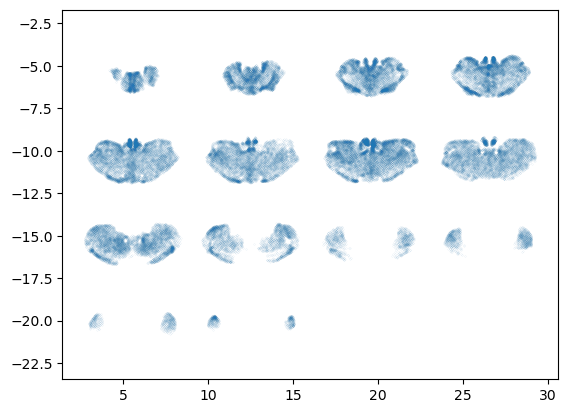

In [11]:
plt.scatter(adata.obs['x_cirro'], adata.obs['y_cirro'], s=0.001)
plt.axis('equal')
plt.show()

## Make color lists for .uns

.uns\["cluster_colors"\] should be a list of colors as hex strings (e.g. #D1C9BA)  in the order of the .obs.cluster.cat.categories

and same for .uns\["subclass_colors"\] matching the categories of .obs.subclass

In [12]:
# no idea if this makes a difference, but sorting it makes it easier for me to 
# check the order is correct
class_cat_sorted = sorted(adata.obs['class'].cat.categories)
adata.obs['class'] = adata.obs['class'].cat.reorder_categories(class_cat_sorted, ordered=False)

subclass_cat_sorted = sorted(adata.obs['subclass'].cat.categories)
adata.obs['subclass'] = adata.obs['subclass'].cat.reorder_categories(subclass_cat_sorted, ordered=False)

supertype_cat_sorted = sorted(adata.obs['supertype'].cat.categories)
adata.obs['supertype'] = adata.obs['supertype'].cat.reorder_categories(supertype_cat_sorted, ordered=False)

cluster_cat_sorted = sorted(adata.obs['cluster'].cat.categories)
adata.obs['cluster'] = adata.obs['cluster'].cat.reorder_categories(cluster_cat_sorted, ordered=False)

In [13]:
# using explicitly .cat.categories.to_list() to ensure the colors are in the right order
adata.uns['class_colors'] = abc.get_color_dictionary(adata.obs['class'].cat.categories.to_list(), 
                                                     'class', 
                                                     label_format='id_label',
                                                     version='20230830', 
                                                     as_list=True)

adata.uns['subclass_colors'] = abc.get_color_dictionary(adata.obs['subclass'].cat.categories.to_list(), 
                                                        'subclass', 
                                                        label_format='id_label',
                                                        version='20230830', 
                                                        as_list=True)

adata.uns['supertype_colors'] = abc.get_color_dictionary(adata.obs['supertype'].cat.categories.to_list(), 
                                                         'supertype', 
                                                         label_format='id_label',
                                                         version='20230830', 
                                                         as_list=True)

adata.uns['cluster_colors'] = abc.get_color_dictionary(adata.obs['cluster'].cat.categories.to_list(), 
                                                       'cluster', 
                                                       label_format='id_label',
                                                       version='20230830', 
                                                       as_list=True)

In [14]:
adata.uns

OverloadedDict, wrapping:
	{'accessed_on': '2023-08-25-12-47-11', 'src': '/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/michaelkunst/MERSCOPES/mouse/atlas/mouse_638850/cirro_folder/atlas_brain_638850_CCF.h5ad', 'counts_transform': 'raw', 'class_colors': ['#FF6600', '#FAA307', '#0D47A1'], 'subclass_colors': ['#CCB65C', '#3B1FCC', '#2E3D66', '#BB7ACC', '#99FF4D', '#553D66', '#73FFCF', '#992A00', '#73F8FF', '#2E0F66', '#3D4566', '#FFB473', '#CC3D76', '#664DFF', '#3D8ACC', '#CC7A9D', '#FF7383', '#16f2f2', '#5C8599', '#076600', '#68e497', '#663D57', '#992E38', '#1C0099'], 'supertype_colors': ['#99FFFC', '#93FF4D', '#29CC1F', '#179930', '#90995C', '#854599', '#9D7ACC', '#663800', '#661F47', '#48663D', '#CCA17A', '#99FFDA', '#CC5C6E', '#660012', '#73FFAB', '#994017', '#A7FF73', '#1FCCC0', '#7AB1CC', '#1F1799', '#CC7A86', '#CC5A3D', '#52660F', '#73FF9B', '#00FF1D', '#453DCC', '#299917', '#99457F', '#4A1FCC', '#FFAF99', '#0F662C', '#483D66', '#466600', '#73E7FF', '#859945', '#FF5A00

## Generate UMAP, tSNE, etc.

### on raw

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


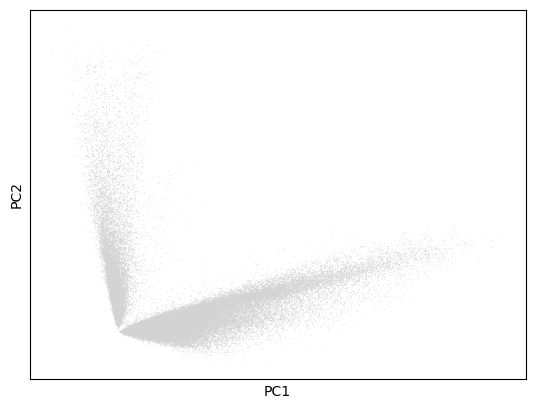

In [15]:
# PCA pre-processing
sc.pp.pca(adata)
sc.pl.pca(adata)

In [16]:
# more pre-processing
sc.pp.neighbors(adata)

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


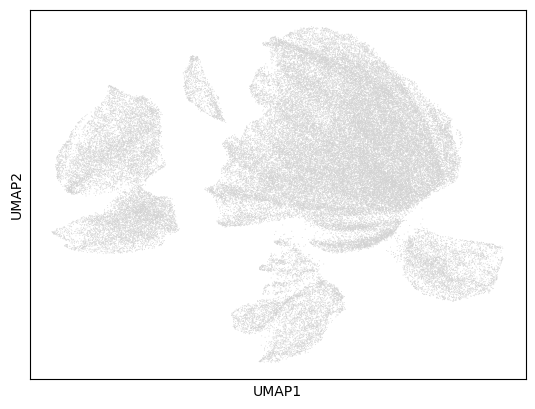

In [17]:
# UMAP
sc.tl.umap(adata)
sc.pl.umap(adata)

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


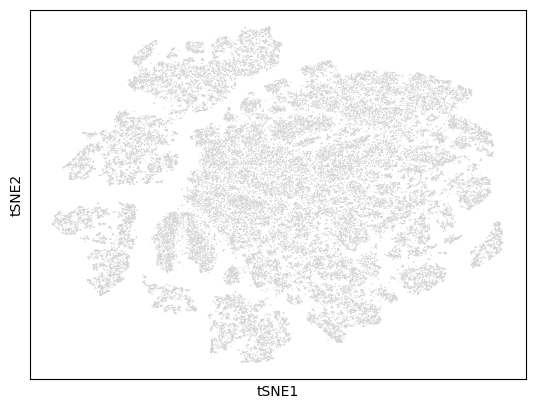

In [18]:
# tSNE - takes much longer than UMAP to run
sc.tl.tsne(adata)
sc.pl.tsne(adata)

In [19]:
adata.obsm

AxisArrays with keys: cirro_spatial, ccf_spatial, X_pca, X_umap, X_tsne

### on log2

In [20]:
# log transform gene expr for dimensionality reduction
adata_log2 = adata.copy()
adata_log2.X = np.asarray(np.log2(1 + adata.X*1e6/np.sum(adata.X.toarray(), axis=1, keepdims=True)))

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


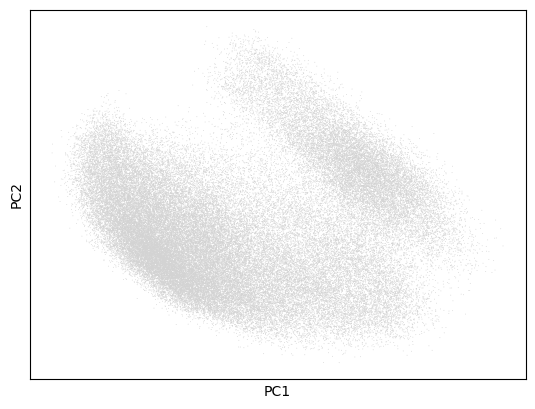

In [21]:
# PCA pre-processing
sc.pp.pca(adata_log2)
sc.pl.pca(adata_log2)

# more pre-processing
sc.pp.neighbors(adata_log2)

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


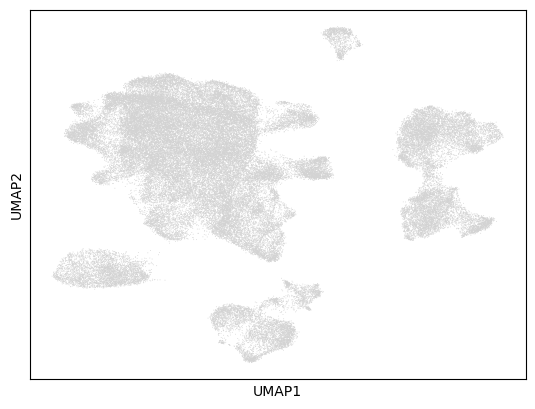

In [22]:
# UMAP
sc.tl.umap(adata_log2)
sc.pl.umap(adata_log2)

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


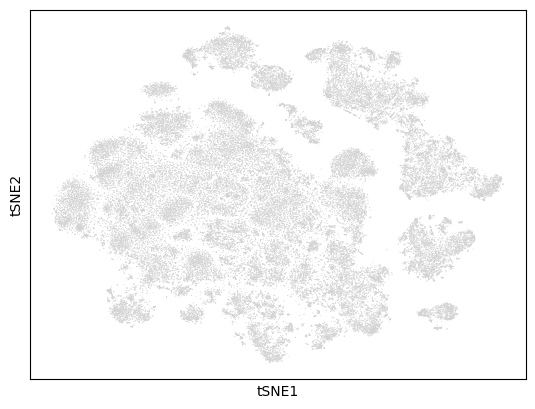

In [23]:
# tSNE - takes much longer than UMAP to run
sc.tl.tsne(adata_log2)
sc.pl.tsne(adata_log2)

In [24]:
adata_log2.obsm

AxisArrays with keys: cirro_spatial, ccf_spatial, X_pca, X_umap, X_tsne

### copy raw results over to adata_log2

In [38]:
adata_log2.obsm['X_umap_raw'] = adata.obsm['X_umap']
adata_log2.obsm['X_tsne_raw'] = adata.obsm['X_tsne']

## Load & save SpaGCN domains results

In [26]:
# load in SpaGCN domain results
# temporarily a static file in '../code/resources' until I get a reproducible run setup for the spagcn capsule
spagcn_domains_df_all = pd.read_parquet('/code/resources/spagcn_predicated_domains.parquet')

# need to convert to categories since they're imported as int64
spagcn_domains_df = spagcn_domains_df_all[['res1pt4']].copy().astype('str')
spagcn_domains_df = spagcn_domains_df.astype('category')
spagcn_domains_df.rename(columns={'res1pt4':'SpaGCN_domains'},inplace=True)
spagcn_domains_df['SpaGCN_domains']

adata_log2.obs = adata_log2.obs.join(spagcn_domains_df, on='cell_label')

adata_log2.obs['SpaGCN_domains'] = adata_log2.obs['SpaGCN_domains'].cat.add_categories('no data').fillna('no data')

adata_log2.obs['SpaGCN_domains']

cell_label
1018093344101120291-2         22
1018093344102320608-3    no data
1018093344101110157-4          8
1018093344101120104-2         18
1018093344102470221-3    no data
                          ...   
1018093345101600622           22
1018093345101940289      no data
1018093345101600851            5
1018093345101950253-1    no data
1018093345101620505           17
Name: SpaGCN_domains, Length: 74523, dtype: category
Categories (31, object): ['0', '1', '11', '12', ..., '7', '8', '9', 'no data']

In [27]:
spg_domain_cats = adata_log2.obs['SpaGCN_domains'].cat.categories
print(f'{spg_domain_cats=}')
spg_palette_sns = sns.color_palette(cc.glasbey, n_colors=len(spg_domain_cats))

# set the 'no data' category color to white so it doesn't show up in cirro
spg_palette_sns[-1] = (1.0, 1.0, 1.0)

# need RGB dict for sns plotting to check colors
palette_dict_sns = dict(zip(spg_domain_cats, spg_palette_sns))

# need hex strings for cirro
spg_palette_cirro = list(spg_palette_sns.as_hex())
print(spg_palette_cirro)

spg_domain_cats=Index(['0', '1', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2',
       '20', '21', '22', '23', '24', '25', '26', '27', '29', '3', '31', '32',
       '4', '5', '6', '7', '8', '9', 'no data'],
      dtype='object')
['#d60000', '#8c3bff', '#018700', '#00acc6', '#97ff00', '#ff7ed1', '#6b004f', '#ffa52f', '#573b00', '#005659', '#0000dd', '#00fdcf', '#a17569', '#bcb6ff', '#95b577', '#bf03b8', '#645474', '#790000', '#0774d8', '#fdf490', '#004b00', '#8e7900', '#ff7266', '#edb8b8', '#5d7e66', '#9ae4ff', '#eb0077', '#a57bb8', '#5900a3', '#03c600', '#ffffff']


(1.4122829008240982,
 30.61779118757324,
 -21.583910682172277,
 -3.556303071736857)

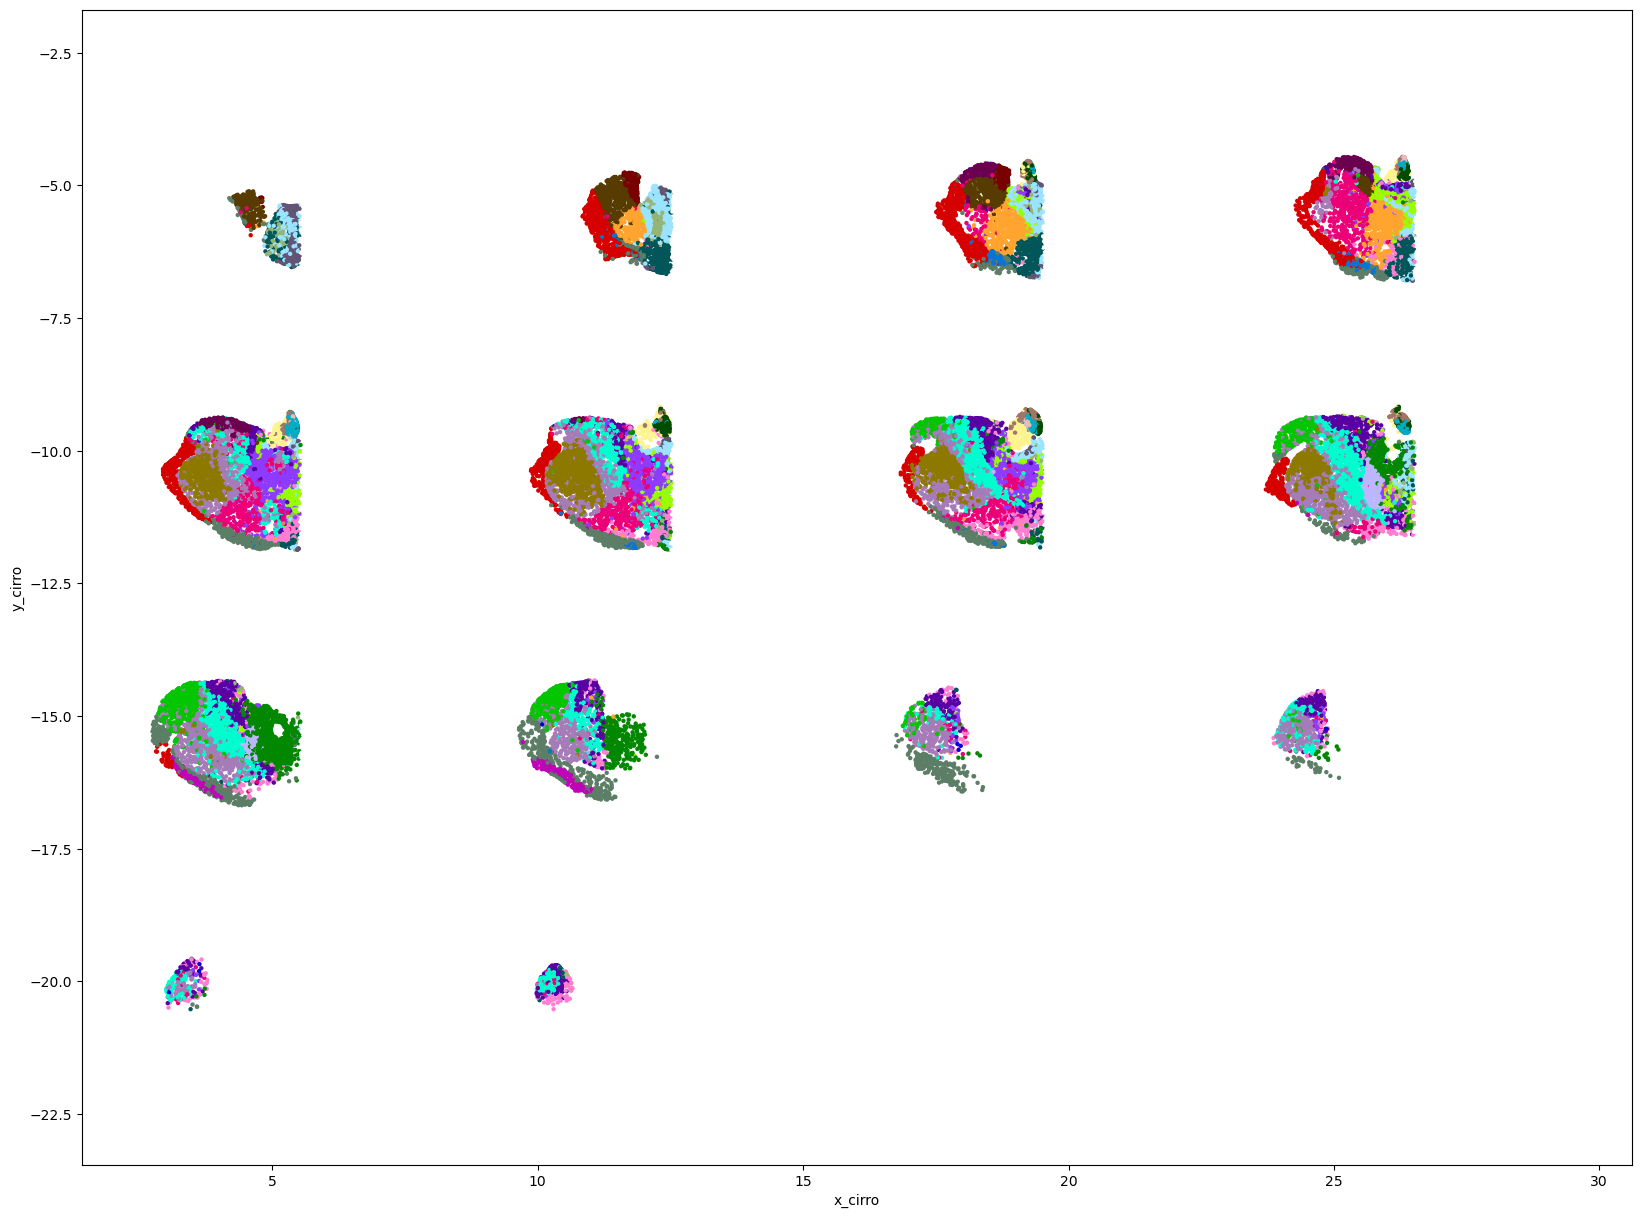

In [28]:
fig = plt.figure(figsize=(20,15))
ax = fig.gca()
sns.scatterplot(adata_log2.obs, ax=ax, x='x_cirro', y='y_cirro', 
                hue='SpaGCN_domains', s=10, palette=palette_dict_sns, 
                linewidth=0, legend=False)
plt.axis('equal')

In [29]:
adata_log2.uns['SpaGCN_domains_color'] = spg_palette_cirro

# Load & save NSF results

In [30]:
adata_nsf = ad.read_zarr("/root/capsule/data/nsf_2000_adata/nsf_2000_adata.zarr")

In [31]:
nsf_cols = ['nsf_tot', 'nsf0', 'nsf1', 'nsf2', 'nsf3', 'nsf4', 
            'nsf5', 'nsf6', 'nsf7', 'nsf8', 'nsf9', 'nsf10', 
            'nsf11', 'nsf12', 'nsf13', 'nsf14', 'nsf15', 'nsf16', 
            'nsf17', 'nsf18', 'nsf19', 'nsf20', 'nsf21', 'nsf22', 
            'nsf23', 'nsf24', 'nsf25', 'nsf26', 'nsf27', 'nsf28', 
            'nsf29']
nsf_df = adata_nsf.obs[nsf_cols].copy()
nsf_df

,nsf_tot,nsf0,nsf1,nsf2,nsf3,nsf4,nsf5,nsf6,nsf7,nsf8,...,nsf20,nsf21,nsf22,nsf23,nsf24,nsf25,nsf26,nsf27,nsf28,nsf29
cell_label,,,,,,,,,,,,,,,,,,,,,
1018093344102490116-4,504.902679,0.001184,0.000319,0.001158,0.003675,0.770119,0.001990,0.027267,0.001629,0.016931,...,0.001601,0.010653,0.003671,0.000488,0.001222,0.001950,0.000532,0.004254,0.000996,0.003392
1018093345102320739,494.795776,0.015365,0.000634,0.007125,0.013677,0.000275,0.007691,0.000389,0.015648,0.107151,...,0.110615,0.002064,0.003663,0.151959,0.222681,0.003510,0.001856,0.006191,0.012567,0.008169
1018093344101520204-6,487.793732,0.026045,0.000822,0.048580,0.000441,0.270117,0.005557,0.012342,0.112307,0.008572,...,0.006474,0.090102,0.004248,0.066157,0.001970,0.006698,0.002039,0.048212,0.001087,0.012348
1017092617101780160-1,531.638306,0.000366,0.000196,0.006236,0.901865,0.001499,0.000668,0.000737,0.004919,0.001393,...,0.001839,0.000959,0.000668,0.000467,0.000941,0.000256,0.000215,0.001959,0.000713,0.006519
1018093344201340262,498.494690,0.104071,0.000644,0.058316,0.001962,0.002068,0.001664,0.000390,0.192760,0.015547,...,0.023974,0.003032,0.007294,0.231134,0.016147,0.000841,0.000552,0.018780,0.002022,0.006946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018093344101510543-2,472.823639,0.036379,0.000373,0.001226,0.000472,0.119669,0.000946,0.003140,0.000715,0.003028,...,0.005620,0.001160,0.000626,0.029157,0.002396,0.000213,0.000258,0.000756,0.000637,0.006960
1019171907102290212,488.520020,0.002556,0.000838,0.257155,0.001263,0.037019,0.001317,0.000456,0.070659,0.004755,...,0.005999,0.001817,0.003306,0.029245,0.005330,0.000888,0.001282,0.213882,0.152381,0.005006
1020131842101740715,524.911133,0.000935,0.000452,0.010906,0.000341,0.002124,0.009457,0.002084,0.001065,0.000569,...,0.000952,0.001363,0.001199,0.000296,0.013797,0.000365,0.000318,0.002206,0.007246,0.009137


In [32]:
adata_log2.obs = adata_log2.obs.join(nsf_df, on='cell_label')
adata_log2.obs.head(3)

,brain_section_label,average_correlation_score,class,cluster,cluster_alias,left_hemisphere,neurotransmitter,parcellation_division,parcellation_index,parcellation_structure,...,nsf20,nsf21,nsf22,nsf23,nsf24,nsf25,nsf26,nsf27,nsf28,nsf29
cell_label,,,,,,,,,,,,,,,,,,,,,
1018093344101120291-2,C57BL6J-638850.30,0.632058,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,True,Glut,TH,315,SGN,...,0.019085,0.006476,0.001565,0.001848,0.003526,0.003133,0.000942,0.022894,0.004984,0.003070
1018093344102320608-3,C57BL6J-638850.30,0.567402,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,False,Glut,TH,539,TH-unassigned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1018093344101110157-4,C57BL6J-638850.30,0.552009,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,True,Glut,TH,315,SGN,...,0.049996,0.004473,0.001734,0.015428,0.023777,0.001602,0.000976,0.012069,0.006774,0.004423


In [33]:
adata_log2.obs[nsf_cols] = adata_log2.obs[nsf_cols].fillna(0)

In [34]:
adata_log2.obs.head(5)

,brain_section_label,average_correlation_score,class,cluster,cluster_alias,left_hemisphere,neurotransmitter,parcellation_division,parcellation_index,parcellation_structure,...,nsf20,nsf21,nsf22,nsf23,nsf24,nsf25,nsf26,nsf27,nsf28,nsf29
cell_label,,,,,,,,,,,,,,,,,,,,,
1018093344101120291-2,C57BL6J-638850.30,0.632058,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,True,Glut,TH,315,SGN,...,0.019085,0.006476,0.001565,0.001848,0.003526,0.003133,0.000942,0.022894,0.004984,0.003070
1018093344102320608-3,C57BL6J-638850.30,0.567402,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,False,Glut,TH,539,TH-unassigned,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1018093344101110157-4,C57BL6J-638850.30,0.552009,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,True,Glut,TH,315,SGN,...,0.049996,0.004473,0.001734,0.015428,0.023777,0.001602,0.000976,0.012069,0.006774,0.004423
1018093344101120104-2,C57BL6J-638850.30,0.509473,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,True,Glut,TH,315,SGN,...,0.123576,0.001483,0.002291,0.017997,0.048304,0.002693,0.001195,0.007884,0.015680,0.004474
1018093344102470221-3,C57BL6J-638850.30,0.619522,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,False,Glut,TH,1077,MG,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Clean up obs

In [35]:
cols_to_remove = ['parcellation_division', 'parcellation_index', 
                  # 'parcellation_structure','parcellation_substructure', 
                  'x_ccf', 'y_ccf', 'z_ccf', 'x_cirro', 'y_cirro']

adata_log2.obs.drop(columns=cols_to_remove, inplace=True)

## Save as h5ad

In [36]:
adata_log2

AnnData object with n_obs × n_vars = 74523 × 500
    obs: 'brain_section_label', 'average_correlation_score', 'class', 'cluster', 'cluster_alias', 'left_hemisphere', 'neurotransmitter', 'parcellation_structure', 'parcellation_substructure', 'subclass', 'supertype', 'x_reconstructed', 'x_section', 'y_reconstructed', 'y_section', 'z_reconstructed', 'z_section', 'SpaGCN_domains', 'nsf_tot', 'nsf0', 'nsf1', 'nsf2', 'nsf3', 'nsf4', 'nsf5', 'nsf6', 'nsf7', 'nsf8', 'nsf9', 'nsf10', 'nsf11', 'nsf12', 'nsf13', 'nsf14', 'nsf15', 'nsf16', 'nsf17', 'nsf18', 'nsf19', 'nsf20', 'nsf21', 'nsf22', 'nsf23', 'nsf24', 'nsf25', 'nsf26', 'nsf27', 'nsf28', 'nsf29'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'counts_transform', 'class_colors', 'subclass_colors', 'supertype_colors', 'cluster_colors', 'pca', 'neighbors', 'umap', 'tsne', 'SpaGCN_domains_color'
    obsm: 'cirro_spatial', 'ccf_spatial', 'X_pca', 'X_umap', 'X_tsne', 'X_umap_raw'
    varm: 'PCs'
    obsp: 'distance

In [39]:
adata_log2.write('/results/wmb_abc_atlas_v20230830_th_nsf_spagcn_for_cirro_log2CPM.h5ad', compression="gzip")

In [40]:
adata.write('/results/wmb_abc_atlas_v20230830_th_nsf_spagcn_for_cirro_raw.h5ad', compression="gzip")

In [41]:
adata_raw = adata_log2.copy()

In [42]:
adata_raw.X = adata.X.copy()

In [43]:
adata_raw.write('/results/wmb_abc_atlas_v20230830_th_nsf_spagcn_for_cirro_raw.h5ad', compression="gzip")

In [46]:
adata_MKlog2X = abc.load_adata_thalamus(version=version, 
                             transform='log2', # will manually norm+log2 later
                             subset_to_TH_ZI=True, 
                             with_metadata=False, 
                             flip_y=True,
                             round_z=True,
                             with_colors=False)

adata_MKlog2X_th_zi_neurons = abc.filter_by_class_thalamus(adata_MKlog2X, 
                                                           filter_nonneuronal=True,
                                                           filter_midbrain=True)

# filter to thalamus boundaries (add a buffer here if wanted)
filter_buffer = 0  # 5
realigned=False
obs_filtered_MKlog2X = abc.filter_by_thalamus_coords(adata_MKlog2X_th_zi_neurons.obs.copy(), 
                                             realigned=realigned, 
                                             buffer=filter_buffer)
adata_MKlog2X_th_zi_neurons = adata_MKlog2X_th_zi_neurons[obs_filtered_MKlog2X.index].copy()

gene_list = [gene for gene in adata_MKlog2X_th_zi_neurons.var_names if 'Blank' not in gene]
adata_MKlog2X_th_zi_neurons = adata_MKlog2X_th_zi_neurons[:,gene_list]

adata_MKlog2X_th_zi_neurons

View of AnnData object with n_obs × n_vars = 74523 × 500
    obs: 'brain_section_label', 'average_correlation_score', 'class', 'cluster', 'cluster_alias', 'left_hemisphere', 'neurotransmitter', 'parcellation_division', 'parcellation_index', 'parcellation_structure', 'parcellation_substructure', 'subclass', 'supertype', 'x_ccf', 'x_reconstructed', 'x_section', 'y_ccf', 'y_reconstructed', 'y_section', 'z_ccf', 'z_reconstructed', 'z_section'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'counts_transform'

In [47]:
adata_log2CPV = adata_log2.copy()
adata_log2CPV.X = adata_MKlog2X_th_zi_neurons.X.copy()

In [49]:
adata_log2CPV.obs.rename(columns={'SpaGCN_domains':'spagcn'},inplace=True)

In [51]:
adata_log2CPV.uns['spagcn_colors'] = adata_log2CPV.uns['SpaGCN_domains_color']

In [52]:
adata_log2CPV.write('/results/wmb_abc_atlas_v20230830_th_nsf_spagcn_for_cirro_log2CPV.h5ad', compression="gzip")